# MultiNest Sampler

In this tutorial we demonstrate how to use the MultiNest sampler with a lightcone, to fit just two astrophysical parameters without noise, and then visualise the results. This tutorial follows a very similar pattern to *MCMC with LightCone* and *MCMC with Multiple Likelihoods*, and you should follow those first.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

%load_ext autoreload
%autoreload 2

import pymultinest
from py21cmmc import mcmc, analyse
from py21cmmc import LikelihoodLuminosityFunction, CoreLuminosityFunction

import py21cmmc
py21cmmc.__version__

'1.0.0dev1'

# MultiNest

To use the MultiNest sampler, you need to install the original MultiNest Program by Farhan Feroz and Mike Hobson (arXiv:0704.3704, 0809.3437 & 1306.2144) as well as its python interface by Johannes Buchner (arXiv: 1402.0004)

https://github.com/JohannesBuchner/MultiNest

https://github.com/JohannesBuchner/PyMultiNest

Note that the current sampler does *not* support outputting model results. Users can only access the MultiNest results including the parameter and likelihood in the posterior.

## Running MultiNest

To perform an MultiNest run is *very* similar to using the default emcee sampler. Merely change ```run_mcmc``` to  ```run_multinest```.

Thus, for example:

In [2]:
model_name = "LuminosityLikelihood"
redshifts  = [6, 7, 8, 10] # redshifts of the provided data
F_STAR10   = [-1.3, -3, 0, 1.0]
ALPHA_STAR = [0.5, -0.5, 1.0, 1.0]
M_TURN     = [8.69897, 8, 10, 1.0]
t_STAR     = [0.5, 0.01, 1, 0.3]

In [ ]:
mcmc_options = {'n_live_points': 600,               # total number of live points
                'importance_nested_sampling': True, # do Importance Nested Sampling (INS)?
                'sampling_efficiency': 0.8,         # 0.8 and 0.3 are recommended for parameter estimation & evidence evalutaion respectively.
                'evidence_tolerance': 0.5,          # A value of 0.5 should give good enough accuracy.
                'max_iter': 20000,                  # maximum iteration
                'multimodal': True,                 # do mode separation?
                }

chainLF = mcmc.run_mcmc(
    [ CoreLuminosityFunction( redshift=z, sigma=0, name='lfz%d'%z) for z in redshifts ], # Assuming no model uncertainties.
    [ LikelihoodLuminosityFunction(name='lfz%d'%z) for z in redshifts ], # No need for datafile or noisefile if using the provided data.
    model_name=model_name,   # Filename of main chain output
    params=dict(             # These parameters require flag_options = {'USE_MASS_DEPENDENT_ZETA': True} when running 21cmFAST.
        F_STAR10 = F_STAR10,
        ALPHA_STAR = ALPHA_STAR,
        M_TURN = M_TURN,
        t_STAR = t_STAR,
    ),
    datadir = '.',
    use_multinest=True,
    **mcmc_options
)

Note that to enable the MPI feature in the MultiNest sampler here (i.e. on Jupyter Notebook), you can use `ipcluster`. 

The result presented in this tutorial was produced in bash by `mpirun -n N python SCRIPT.py`

## Analysis

### Tracking the nest status

Users can track the progress by plotting the likelihood vs prior volume using the ev.dat file

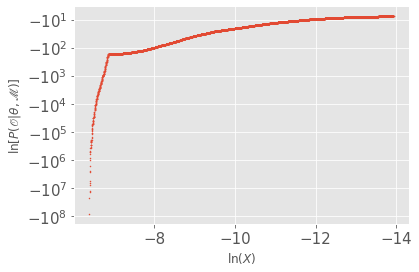

In [4]:
evs = np.loadtxt('./MultiNest/%sev.dat'%model_name)
plt.scatter(evs[:,-2],evs[:,-3],s=1)
plt.yscale('symlog')
plt.xlabel(r'$\ln(X)$')
plt.ylabel(r'$\ln[P(\mathscr{O}|\theta, \mathscr{M})]$')
plt.gca().invert_xaxis()

### Corner Plot

MultiNest returns normalized parameters, users need to rescale them to the initial range.

In [5]:
nest  = pymultinest.Analyzer(4, outputfiles_basename = './MultiNest/%s'%model_name)
data  = nest.get_data()

labels = [r'$f_{*,10}$', r'$\alpha_*$', r'$M_{\rm turn}$', r'$t_*$']
limits = np.array([F_STAR10[1:3], ALPHA_STAR[1:3], M_TURN[1:3], t_STAR[1:3]])
samples = data[:,2:] * (limits[:,1] - limits[:,0]) + limits[:,0]
best_fit = nest.get_best_fit()['parameters'] * (limits[:,1] - limits[:,0]) + limits[:,0] 

  analysing data from ./MultiNest/LuminosityLikelihood.txt


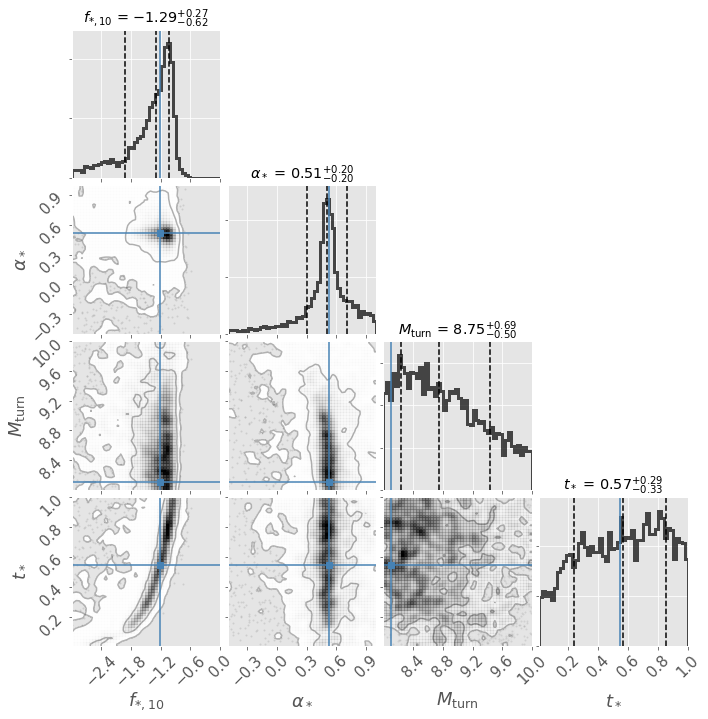

In [6]:
import corner

fig, axs = plt.subplots(4,4,figsize=(10,10))

figure = corner.corner(samples, bins=50,range=limits,alpha=0.5, labels=labels, fig=fig,
                       truths_color='black',truths=best_fit,quantiles=[0.16,0.5,0.84], show_titles=True,
                       hist_kwargs={"alpha":0.7,'linestyle':'-','lw':3},
                       plot_contour=True,levels=[0.68,0.95],
                       contour_kwargs = {'alpha':0.3},label_kwargs={'fontsize':18}, smooth=1)